In [1]:
import torch
import numpy as np
from Model import Net
from Dataloader import AudioDataset
from helpers import Reconstruct, Viz_Y

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.wavfile import read, write
from scipy import signal


from torch.optim import LBFGS, Adam,SGD
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import warnings 

warnings.simplefilter('ignore')

In [8]:
def gain_params(s1,s2,y):

        l2_s1 = torch.norm(s1.float(),2, None)
                 
        l2_s2 = torch.norm(s2.float(),2, None)
               
        l2_Y = torch.norm(y.float(),2, None)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
def gain_params_vec(s1,s2,y):

        l2_s1 = torch.norm(s1.float().t(),2, True)
                 
        l2_s2 = torch.norm(s2.float().t(),2, True)
               
        l2_Y = torch.norm(y.float().t(),2, True)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
    
def feed_(x):
    
    f = model(x)
    f1 = f[0] 
    f2 = f[1]
    return f1,f2

def energy_1(x_source1):
    
    f1,f2 = feed_(x_source1)
    e1 = (1 - f1 ).pow(2) + f2.pow(2)
    return e1 

def energy_2(x_source2):

    f1,f2 = feed_(x_source2)
    e2 = f1.pow(2) + (1 - f2 ).pow(2) 
    return e2

def E_err(s1,s2,y):
  
    u,v = gain_params_vec(s1,s2,y) 
    return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

def E_err_vec(s1,s2,y,u,v):
  
    return torch.norm(u*s1 + v*s2 - y,'fro',None)


def relu(x):
    return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y,u,v):  
    
    u_sum  = torch.sum(relu(u))
    v_sum  = torch.sum(relu(v))
    x1_sum = torch.sum(relu(s1))
    x2_sum = torch.sum(relu(s2))
    total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

    return total_sum 


def nonneg_constraint(s1,s2,u,v):
    
    R=min([s1.min().item(),s2.min().item(),u,v,0])
    
    return R**2

In [2]:
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

False
cpu


# Read audio file:

In [3]:
samplerate, data = read("../data/mix_signal.wav")
music=data[:500000,0]
length=music.shape[0]/samplerate
print('Shape of the data {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate))

Shape of the data 500000
Length : 11.34s
Sample rate : 44100


# Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size


In [4]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512


f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs=np.abs(Y)

In [ ]:
Viz_Y(Yabs,t ,f)

# Apply NMF :

In [5]:
n_components=2
scaler = MinMaxScaler()
Yabs = scaler.fit_transform(Yabs)
Yabs[Yabs==0]=0.001
scaler
model = NMF(n_components=n_components, init='random',alpha=0.5,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
B = model.fit_transform(Yabs)
G = model.components_

Sources = Reconstruct(n_components, B, G, Yabs)

Source shape = (257, 2606)


In [9]:
s1 = torch.tensor(Sources[0], dtype = torch.double)
s2 = torch.tensor(Sources[1])
Yabs = torch.tensor(Yabs)
u0,v0 = gain_params_vec(s1, s2, Yabs)

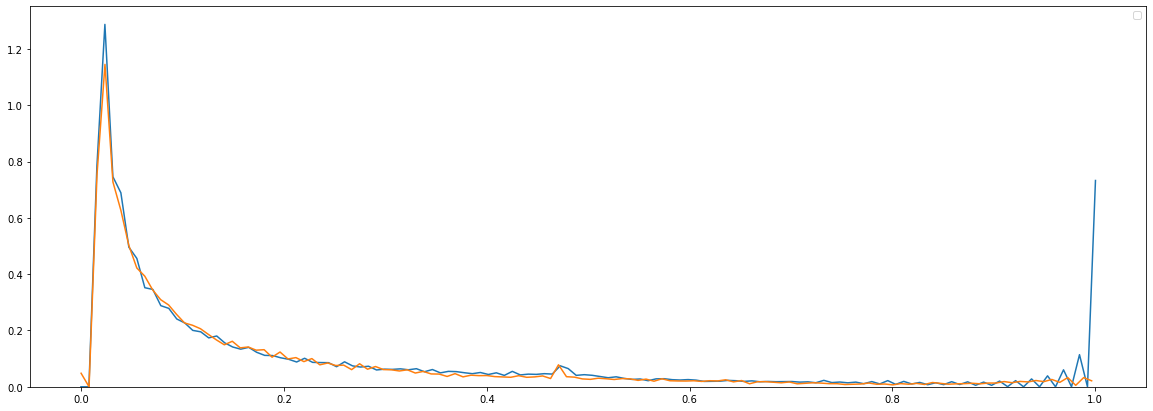

In [10]:
fig,ax=plt.subplots(1,1,figsize=(20,7))
g = sns.distplot(Yabs.detach().numpy(),hist=False,ax=ax)
g = sns.distplot((u0*s1+v0*s2).detach().numpy(), hist = False,ax=ax)
ax.legend(['Yabs','reconstruction'])

In [12]:
L2_LOSS=torch.norm(u0*s1 + v0*s2 - Yabs,'fro',None)
print('Initial Loss = {}'.format(L2_LOSS))

Initial Loss = 22.43038603462996


 # Learning Loop :

* Define optimizer with all parameters W , x1 , x2 , u , v
* Dataloader gives a batch that we loop accross
* For each sample we feed the network with X1 and then we get f1 
* We feed with X2 and we get f2
* We compute u and v using the function.
* We compute the total loss.
* Loss.back()
* Optimizer step 

# Train the DNN :

In [13]:
s1 = torch.tensor(Sources[0])
s2 = torch.tensor(Sources[1])
Yabs = torch.tensor(Yabs)

u,v = gain_params_vec(s1, s2, Yabs)
u.requires_grad = True
v.requires_grad = True
#print('u0 = {:.2f} , v0 = {:.2f}'.format(u,v)) 

In [14]:

s1.requires_grad = True
s2.requires_grad = True
Yabs.requires_grad = False

In [15]:
model = Net(257)
print(model)


Net(
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=257, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=2, bias=True)
)


In [16]:
def Criteria(s1,s2,Yabs,u,v,i) :
    
    # Feed forward and get energy 1 and 2
    e1 = energy_1(s1[:,i].float())
    e2 = energy_2(s2[:,i].float())
    
    # Get least square error :
    e_rr=E_err_vec(s1[:,i], s2[:,i], Yabs[:,i],u[i],v[i])
    
    # Non negative constraint
    R = nonneg_constraint(s1[:,i], s2[:,i], u[i], v[i])
    
    # Compute total Loss :
    
    return e1 + e2 + e_rr + R
    

In [17]:
print(u)

tensor([0.7003, 0.6436, 0.6608,  ..., 0.7315, 0.8130, 0.9657],
       requires_grad=True)


In [18]:
print(v)

tensor([0.5497, 0.5857, 0.5915,  ..., 0.5463, 0.3896, 0.1118],
       requires_grad=True)


In [19]:
print(s1)

tensor([[3.3228e-02, 9.2628e-02, 1.9641e-02,  ..., 7.6697e-02, 2.3944e-01,
         1.0606e-01],
        [3.9372e-02, 5.5057e-02, 5.5043e-02,  ..., 2.6710e-02, 2.1651e-01,
         1.8769e-01],
        [3.2987e-01, 5.8061e-01, 8.7852e-01,  ..., 2.5300e-01, 6.5915e-01,
         6.5451e-01],
        ...,
        [1.9417e-02, 2.4556e-03, 3.0206e-03,  ..., 7.1451e-06, 2.9168e-04,
         3.6695e-03],
        [2.5670e-02, 5.0725e-03, 9.5691e-04,  ..., 4.2338e-06, 6.8366e-04,
         6.4428e-03],
        [2.3430e-02, 8.7846e-03, 1.9925e-03,  ..., 5.0858e-06, 2.4461e-04,
         7.0179e-03]], dtype=torch.float64, requires_grad=True)


params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= LBFGS(params, lr=0.1, max_iter=20, tolerance_grad=1e-07)
model.train()
for i in range(s1.shape[1]):
    
    def closure():
        optimizer.zero_grad()
        loss = Criteria(s1,s2,Yabs,u,v,i)
        loss.backward()
        return loss
        
        
    print('step i= {}'.format(i))
    optimizer.step(closure)

In [21]:
params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= SGD(params, lr=0.05)

In [22]:
model.train()

for e in range(10):
    
    loss_e=0.0
    for i in range(s1.shape[1]):

            optimizer.zero_grad()
            loss = Criteria(s1,s2,Yabs,u,v,i)
            loss.backward()
            # fill zeros into the first row of grad
            u.grad.data[:i].fill_(0)
            u.grad.data[i+1:].fill_(0)
            
            v.grad.data[:i].fill_(0)
            v.grad.data[i+1:].fill_(0)
            s1.grad.data[:,:i].fill_(0)
            s1.grad.data[:,i+1:].fill_(0)
            s2.grad.data[:,:i].fill_(0)
            s2.grad.data[:,i+1:].fill_(0)



            optimizer.step()
            loss_e+=loss
            
    print('Epoch {} , Loss = {:.2f}'.format(e,loss_e/s1.shape[1]))

Epoch 0 , Loss = 1.38
Epoch 1 , Loss = 1.30
Epoch 2 , Loss = 0.69
Epoch 3 , Loss = 0.16
Epoch 4 , Loss = 0.08
Epoch 5 , Loss = 0.05
Epoch 6 , Loss = 0.08
Epoch 7 , Loss = 0.07


KeyboardInterrupt: 

## Check that all values are positive:

In [23]:
print('Min of s1 {:.4f}'.format(s1.min()))
print('Min of s2 {:.4f}'.format(s2.min()))
print('Min of U {:.4f}'.format(u.min()))
print('Min of V {:.4f}'.format(v.min()))

Min of s1 -0.2535
Min of s2 -0.1489
Min of U 0.0005
Min of V 0.0068


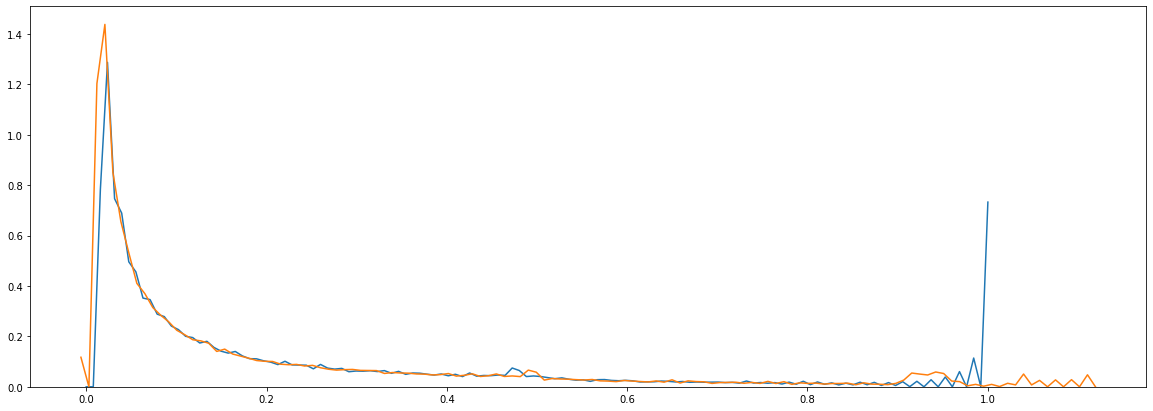

In [26]:
plt.figure(figsize=(20,7))
sns.distplot(Yabs.detach().numpy(),hist=False)
sns.distplot((u*s1+v*s2).detach().numpy(), hist = False)

In [25]:
torch.norm(u*s1 + v*s2 - Yabs,'fro',None)

tensor(5.4426, dtype=torch.float64, grad_fn=<CopyBackwards>)